In [220]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pl
import matplotlib.patches as mpatches
from LIBS_handler import LIBS_Toolkit
import matplotlib.pyplot as plt
from skimage import io
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.mixture import GaussianMixture
from scipy.ndimage import gaussian_filter
import os

def add_alpha_to_colormap(cmap, start_alpha=0, end_alpha=1):
    N = cmap.N
    colors = cmap(np.linspace(0, 1, N))
    if colors.ndim != 2 or colors.shape[1] != 4:
        raise ValueError("The colormap must be a 2D array with 4 columns (RGBA).")
    alphas = np.linspace(start_alpha, end_alpha, N)
    colors[:, 3] = alphas
    new_cmap = LinearSegmentedColormap.from_list("custom_red_alpha", colors, N=N)
    return new_cmap

cmap1 = LinearSegmentedColormap.from_list('custom red', ['#244162', 'xkcd:red'], N = 256)
cmap2 = LinearSegmentedColormap.from_list('custom orange', ['#244162', 'xkcd:bright orange'], N = 256)

my_cmap = add_alpha_to_colormap(cmap1)
my_cmap2 = add_alpha_to_colormap(cmap2)

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
%autoreload 1
%autoreload 2

# 1. Initialize Class

In [2]:
fname = r"E:/Data/Data_LIBS/Vidros/mixed_ba_pro"

In [3]:
libs_mainupulator = LIBS_Toolkit(fname, overwrite = True)
libs_mainupulator.load_dataset(baseline_corrected = True)

In [4]:
optical_dset = io.imread(r"E:/Data/Data_LIBS/Vidros/mixed_ba.png")

## 1.2 Perform basic preprocessing

 -> Baseline Removal 
 
 -> Normalize to Sum

In [5]:
# _ = libs_mainupulator.baseline_correct()
_ = libs_mainupulator.normalize_to_sum()

## 1.3 Basic Visualization of Single Emission line along with average Spectrum

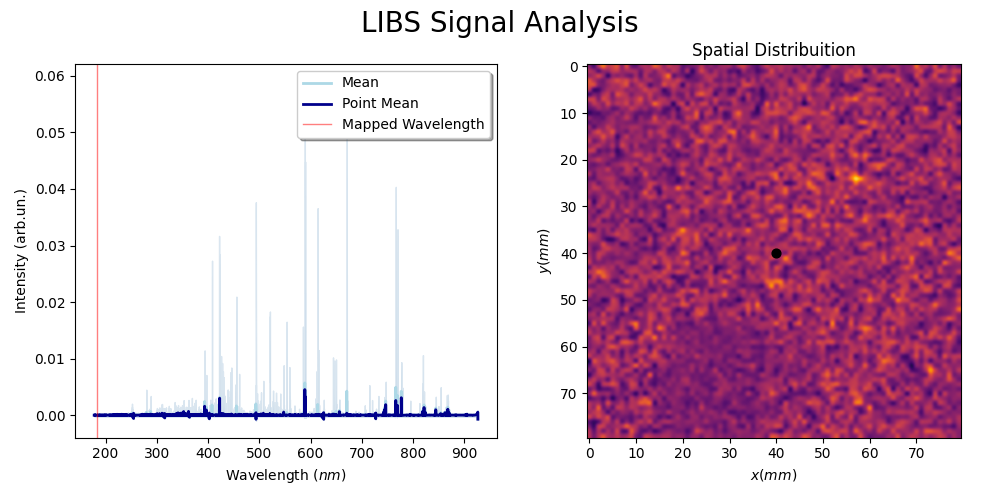

In [6]:
%matplotlib widget
libs_mainupulator.standard_analysis(radius = 5)

## 1.4 Save all lines for analysis

In [245]:
element_table = [
    {"Element": "Si", "Emission Lines": [288.13, 252.82, 250.57, 252.3]},
    {"Element": "O" , "Emission Lines": [777.12, 777.34, 715.59, 615.98]},
    {"Element": "Na", "Emission Lines": [588.87, 589.47, 568.7, 568.12]},
    {"Element": "K" , "Emission Lines": [766.4, 769.77]},
    {"Element": "Ca", "Emission Lines": [422.67, 430.27, 445.45, 643.89, 646.27]},
    {"Element": "Mn", "Emission Lines": [279.5, 279.77, 279.97, 403.07]},
    {"Element": "Al", "Emission Lines": [396.09, 309.22, 394.34, 308.17, 257.48]},
    {"Element": "Fe", "Emission Lines": [259.89, 275.52, 261.15, 273.93]},
    {"Element": "Mg", "Emission Lines": [285.18, 383.76, 383.15, 518.22, 278.12]},
    {"Element": "Cr", "Emission Lines": [358.06, 302.03, 425.43]},
    {"Element": "Co", "Emission Lines": [356.96, 340.42, 350.35, 345.31]},
    {"Element": "Ga", "Emission Lines": [417.26, 403.35, 287.56]},
    {"Element": "Cr", "Emission Lines": [302.01, 425.43]},
    {"Element": "Ba", "Emission Lines": [553.42, 611.2, 649.69]},
    {"Element": "Pb", "Emission Lines": [261.49, 283.09, 368.32]},
    {"Element": "Sr", "Emission Lines": [460.68, 548.07, 481.01]},
    {"Element": "Zr", "Emission Lines": [339.2, 343.82, 349.62, 468.78, 471.01, 473.95]},
    {"Element": "Hf", "Emission Lines": [356.14, 339.96, 713.11]},
    {"Element": "Zn", "Emission Lines": [334.46, 330.25, 328.28]}
                 ]

libs_mainupulator.update_elements(np.array([element_table[i]['Element'] for i in range(len(element_table))]))
# _ = libs_mainupulator.manual_features(np.concatenate([element_table[i]['Emission Lines'] for i in range(len(element_table))]), sigma = 1)
_ = libs_mainupulator.manual_features(np.array([394.74, 422.67, 425.43, 460.68, 468.78, 649.69, 777.12]), sigma = 1)

# from matplotlib.colors import LogNorm
# sigma = 0.5
# for i in range(len(element_table)):
#     element = element_table[i]["Element"]
#     lines = element_table[i]["Emission Lines"]
#     for j, line in enumerate(lines):
#         directory = f"Images/{element}"
#         os.makedirs(directory, exist_ok = True)
#         mmap = gaussian_filter(libs_mainupulator.dataset[:, :, libs_mainupulator.wavelength_to_index(line)], sigma = sigma)
#         mmap = (mmap - mmap.min())/(mmap.max() - mmap.min())

#         fig, ax = plt.subplots(figsize = (5, 4))
#         ax.set_title(f"{element} - {line:.2f} nm", fontsize = 16)
#         cax = ax.imshow(mmap, cmap = 'inferno', extent = (0, 40, 0, 40))
#         cbar = fig.colorbar(cax, ax = ax, fraction = 0.046, pad = 0.04)
#         ax.set_xticks([0, 40])
#         ax.set_yticks([0, 40])
#         ax.set_xticklabels([0, 40], fontsize = 14)
#         ax.set_yticklabels([0, 40], fontsize = 14)
#         plt.savefig(f"{directory}/Final_{line}nm.png", bbox_inches = 'tight')
#         plt.close() 

# 2. Classification

## 2.1 Perform k-means clustering

In [246]:
element_names = ["Al", "Ca", "Cr", "Sr", "Zr", "Ba", "Ba", "O"]
init_clusters = np.array([
    [0, 1, 0, 0, 0, 0, 1], # Vidros Bons
    [1, 0, 0, 0, 0, 0, 1], # Raw Material
    [0, 1, 1, 0, 0, 0, 0], # Metais
    [0.5, 0, 0, 0, 0, 0.5, 1], # Refratários Ba e Al
    [0, 0, 0, 1, 0, 1, 0] # Refratários Ba e Sr
])

colors = ["xkcd:frog green", "xkcd:beige", "xkcd:indian red", "xkcd:red", "xkcd:salmon"]
cmap = ListedColormap(colors)

preprocess = MaxAbsScaler()
classifier = KMeans(n_clusters = 5, init = init_clusters)


scaled_dset = preprocess.fit_transform(libs_mainupulator.features.reshape(-1, libs_mainupulator.x_size*libs_mainupulator.y_size).T)
# scaled_dset = libs_mainupulator.features.reshape(-1, libs_mainupulator.x_size*libs_mainupulator.y_size).T

labelled = classifier.fit_predict(scaled_dset).reshape(libs_mainupulator.x_size, libs_mainupulator.y_size)

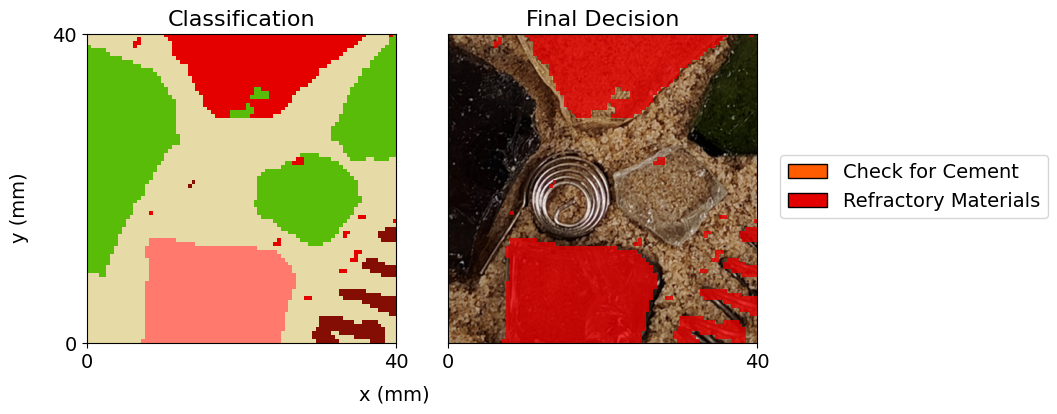

In [249]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4))

ax = axs[0]
ax.set_title("Classification", fontsize = 16)
ax.imshow(labelled, cmap = cmap, extent = (0, 40, 0, 40))
ax.set_xticks([0, 40])
ax.set_yticks([0, 40])
ax.set_xticklabels([0, 40], fontsize = 14)
ax.set_yticklabels([0, 40], fontsize = 14)


mask_reject = (labelled == 2) + (labelled == 3) + (labelled == 4)


ax = axs[1]
ax.set_title("Final Decision", fontsize = 16)
ax.imshow(optical_dset, extent = (0, 40, 0, 40))
ax.imshow(mask_reject, cmap = my_cmap, extent = (0, 40, 0, 40), alpha = 0.8)
ax.set_xticks([0, 40])
ax.set_yticks([])
ax.set_xticklabels([0, 40], fontsize = 14)

fig.supxlabel('x (mm)', fontsize = 14)
fig.supylabel('y (mm)', fontsize = 14)

cols = ['xkcd:bright orange', 'xkcd:red']
names = ["Check for Cement", "Refractory Materials"]
handles = []
hls = []
for col, name in zip(cols, names):
    patch = mpatches.Patch(color = col, label = name, ec = 'k')
    hls.append(patch)
fig.legend(handles = hls, loc = 'lower center', ncol = 1, fontsize = 14, bbox_to_anchor = (1.15, 0.45))

fig.tight_layout()
# fig.savefig("Images/Final_decision.png", dpi = 300, bbox_inches = 'tight')

MovieWriter imagemagick unavailable; using Pillow instead.


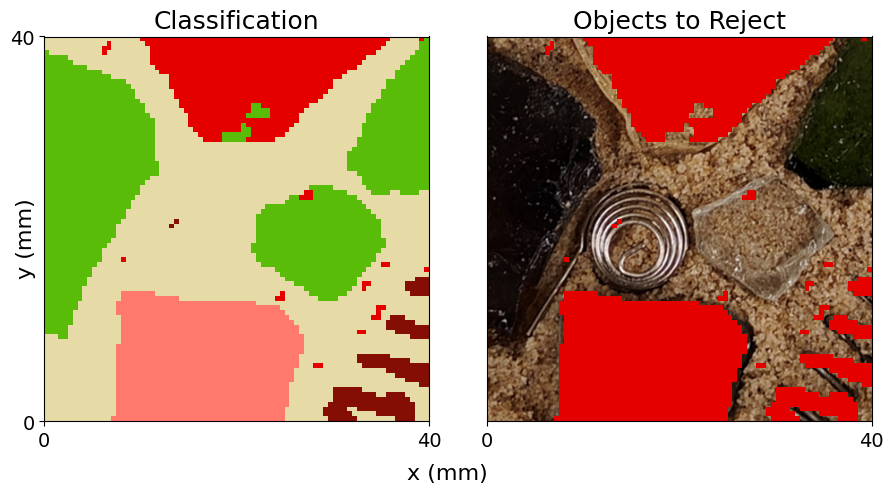

In [223]:
import matplotlib.animation as animation

rejection_inds = [100, 2, 3, 4, 1000]
contaminant_names = ["Contamined Dataset", "Metal Contaminants", "Ba and Al Contaminants", "Ba and Sr Contaminants"]


def make_animation(dataset, contaminant_names):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 5))
    fig.tight_layout()
    fig.supxlabel("x (mm)", fontsize = 16)
    fig.supylabel("y (mm)", fontsize = 16)

    
    mask_reject = np.zeros(labelled.shape)
    optical_image = optical_dset

    im1 = ax1.imshow(labelled, cmap = cmap, extent = (0, 40, 0, 40))
    ax1.set_title("Classification", fontsize = 18)
    ax1.set_xticks([0, 40])
    ax1.set_yticks([0, 40])
    ax1.set_xticklabels([0, 40], fontsize = 14)
    ax1.set_yticklabels([0, 40], fontsize = 14)

    ax2.imshow(optical_image, extent = (0, 40, 0, 40))
    im2 = ax2.imshow(mask_reject, cmap = my_cmap, vmin = 0, vmax = 1, extent = (0, 40, 0, 40))
    ax2.set_xticks([0, 40])
    ax2.set_yticks([])
    ax2.set_xticklabels([0, 40], fontsize = 14)

    def update(index):
        if dataset[index] == 1000:
             mask_reject[:] = (labelled == 2) + (labelled == 3) + (labelled == 4)
             ax2.set_title(f"Objects to Reject", fontsize = 18)
        else:
            mask_reject[:] = (labelled == dataset[index])
            ax2.set_title(f"{contaminant_names[index]}", fontsize = 18)
        im2.set_data(mask_reject)
        
        return [im1, im2]

    ani = animation.FuncAnimation(fig, update, frames = len(dataset), interval = 1000, blit = True, repeat = False)

    ani.save(r'Images/animation_classifier_new.gif', writer = 'imagemagick')

make_animation(rejection_inds, contaminant_names)

# 3. Set with Cement

In [98]:
fname = r"E:/Data/Data_LIBS/Vidros/mixed_ba__cement_100_1_pro.h5"
libs_main2 = LIBS_Toolkit(fname, overwrite = True)
libs_main2.load_dataset(baseline_corrected = True)

In [151]:
optical_dset2 = io.imread(r"Images2/dset_mixture2.png")

In [100]:
_ = libs_main2.normalize_to_sum()

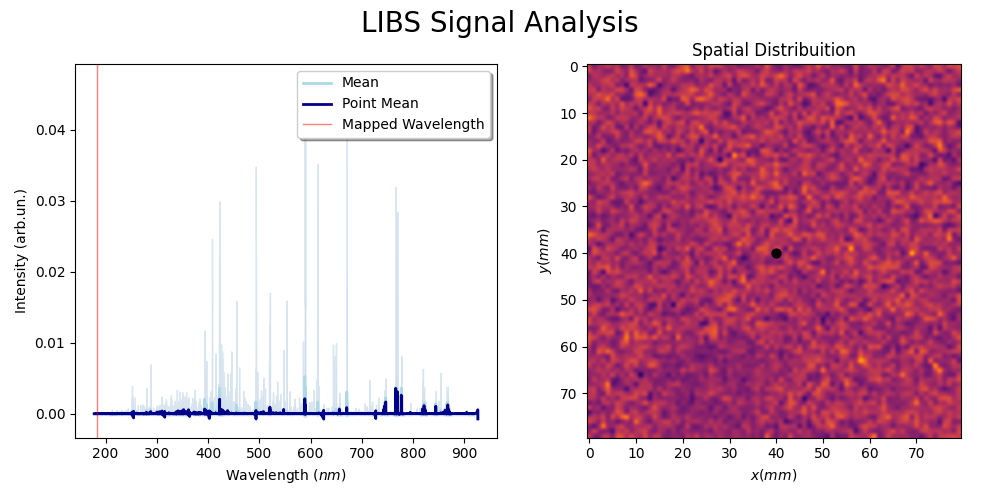

In [315]:
%matplotlib widget
libs_main2.standard_analysis(radius = 5)

In [255]:
element_table = [
                 {"Element": "Si", "Emission Lines": [288.13, 252.82, 250.57, 252.3]},
                 {"Element": "O" , "Emission Lines": [777.12, 777.34, 715.59, 615.98]},
                 {"Element": "Na", "Emission Lines": [588.87, 589.47, 568.7, 568.12]},
                 {"Element": "K" , "Emission Lines": [766.4, 769.77]},
                 {"Element": "Ca", "Emission Lines": [422.67, 430.27, 445.45, 643.89, 646.27]},
                 {"Element": "Mn", "Emission Lines": [279.5, 279.77, 279.97, 403.07]},
                 {"Element": "Al", "Emission Lines": [396.09, 309.22, 394.34, 308.17, 257.48]},
                 {"Element": "Fe", "Emission Lines": [259.89, 275.52, 261.15, 273.93]},
                 {"Element": "Mg", "Emission Lines": [285.18, 383.76, 383.15, 518.22, 278.12]},
                 {"Element": "Cr", "Emission Lines": [358.06, 302.03, 425.43]},
                 {"Element": "Co", "Emission Lines": [356.96, 340.42, 350.35, 345.31]},
                 {"Element": "Ga", "Emission Lines": [417.26, 403.35, 287.56]},
                 {"Element": "Cr", "Emission Lines": [302.01, 425.43]},
                 {"Element": "Ba", "Emission Lines": [553.42, 611.2, 649.69]},
                 {"Element": "Pb", "Emission Lines": [261.49, 283.09, 368.32]},
                 {"Element": "Sr", "Emission Lines": [460.68, 548.07, 481.01]},
                 {"Element": "Zr", "Emission Lines": [339.2, 343.82, 349.62, 468.78, 471.01, 473.95]},
                 {"Element": "Hf", "Emission Lines": [356.14, 339.96, 713.11]},
                 {"Element": "Zn", "Emission Lines": [334.46, 330.25, 328.28]}
                 ]

libs_main2.update_elements(np.array([element_table[i]['Element'] for i in range(len(element_table))]))
# _ = libs_main2.manual_features(np.concatenate([element_table[i]['Emission Lines'] for i in range(len(element_table))]), sigma = 1)
_ = libs_main2.manual_features(np.array([394.74, 422.67, 425.43, 460.68, 468.78, 649.69, 777.12]), sigma = 1)


# from matplotlib.colors import LogNorm
# sigma = 0.5
# for i in range(len(element_table)):
#     element = element_table[i]["Element"]
#     lines = element_table[i]["Emission Lines"]
#     for j, line in enumerate(lines):
#         directory = f"Images2/{element}"
#         os.makedirs(directory, exist_ok = True)
#         mmap = gaussian_filter(libs_main2.dataset[:, :, libs_main2.wavelength_to_index(line)], sigma = sigma)
#         mmap = (mmap - mmap.min())/(mmap.max() - mmap.min())

#         fig, ax = plt.subplots(figsize = (5, 4))
#         ax.set_title(f"{element} - {line:.2f} nm", fontsize = 16)
#         cax = ax.imshow(mmap, cmap = 'inferno', extent = (0, 40, 0, 40))
#         cbar = fig.colorbar(cax, ax = ax, fraction = 0.046, pad = 0.04)
#         ax.set_xticks([0, 40])
#         ax.set_yticks([0, 40])
#         ax.set_xticklabels([0, 40], fontsize = 14)
#         ax.set_yticklabels([0, 40], fontsize = 14)
#         plt.savefig(f"{directory}/Final_{line}nm.png", bbox_inches = 'tight')
#         plt.close() 

In [267]:
element_names = ["Al", "Ca", "Cr", "Sr", "Zr", "Ba", "O"]
init_clusters2 = np.array([
    [0, 1, 0, 0, 0, 0, 1], # Vidros Bons
    [1, 0, 0, 0, 0, 0, 1], # Raw Material
    [0, 0, 1, 0, 0, 0, 0], # Metais
    [0.5, 0, 0, 0, 0, 0.5, 1], # Refratários Ba e Al
    [0, 0, 0, 1, 0, 1, 0], # Refratários Ba e Sr
    [1, 0, 0, 0, 1, 0, 1] # Cimento na Areia
])

colors = ["xkcd:frog green", "xkcd:beige", "xkcd:indian red", "xkcd:red", "xkcd:salmon", "xkcd:bright orange"]
cmap = ListedColormap(colors)

preprocess2 = MinMaxScaler()
classifier2 = KMeans(n_clusters = 6, init = init_clusters2)


scaled_dset2 = preprocess2.fit_transform(libs_main2.features.reshape(-1, libs_main2.x_size*libs_main2.y_size).T)
scaled_dset2[:, 2] = 2*scaled_dset2[:, 2]

# scaled_dset = libs_main2.features.reshape(-1, libs_main2.x_size*libs_main2.y_size).T

labelled2 = classifier2.fit_predict(scaled_dset2).reshape(libs_main2.x_size, libs_main2.y_size)

MovieWriter imagemagick unavailable; using Pillow instead.


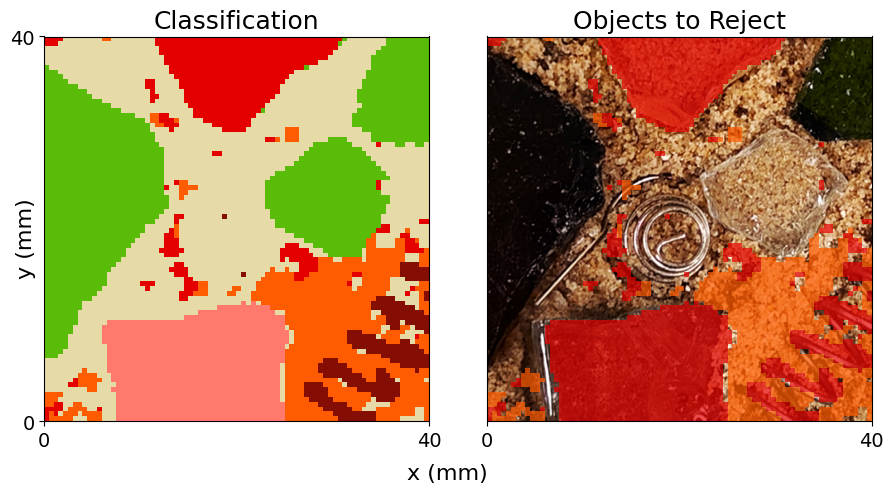

In [236]:
import matplotlib.animation as animation

rejection_inds = [100, 2, 3, 4, 2000, 1000]
contaminant_names = ["Contamined Dataset", "Metal Contaminants", "Ba and Al Contaminants", "Ba and Sr Contaminants", "Cement Contaminant"]


def make_animation(dataset, contaminant_names):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 5))
    fig.tight_layout()
    fig.supxlabel("x (mm)", fontsize = 16)
    fig.supylabel("y (mm)", fontsize = 16)

    
    mask_reject = np.zeros(labelled2.shape)
    optical_image = optical_dset2

    im1 = ax1.imshow(labelled2, cmap = cmap, extent = (0, 40, 0, 40))
    ax1.set_title("Classification", fontsize = 18)
    ax1.set_xticks([0, 40])
    ax1.set_yticks([0, 40])
    ax1.set_xticklabels([0, 40], fontsize = 14)
    ax1.set_yticklabels([0, 40], fontsize = 14)

    ax2.imshow(optical_image, extent = (0, 40, 0, 40))
    im2 = ax2.imshow(mask_reject, cmap = my_cmap, vmin = 0, vmax = 1, extent = (0, 40, 0, 40), alpha = 0.7)
    ax2.set_xticks([0, 40])
    ax2.set_yticks([])
    ax2.set_xticklabels([0, 40], fontsize = 14)

    def update(index):
        if dataset[index] == 1000:
             mask_reject[:] = (labelled2 == 2) + (labelled2 == 3) + (labelled2 == 4)
             ax2.set_title(f"Objects to Reject", fontsize = 18)
             im2.set_data(mask_reject)
        elif dataset[index] == 2000:
            im2.set_data(np.zeros_like(mask_reject))
            mask_reject2[:] = (labelled2 == 5)
            ax2.imshow(mask_reject2, cmap = my_cmap2, vmin = 0, vmax = 1, extent = (0, 40, 0, 40), alpha = 0.7)
        else:
            mask_reject[:] = (labelled2 == dataset[index])
            ax2.set_title(f"{contaminant_names[index]}", fontsize = 18)
            im2.set_data(mask_reject)
        
        return [im1, im2]

    ani = animation.FuncAnimation(fig, update, frames = len(dataset), interval = 1500, blit = True, repeat = False)

    ani.save(r'Images/animation_classifier_new_with_cement.gif', writer = 'imagemagick')

make_animation(rejection_inds, contaminant_names)

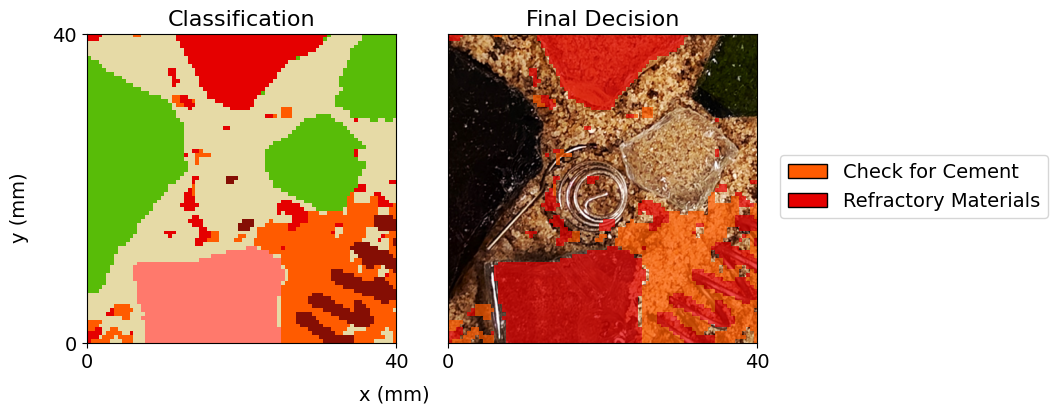

In [268]:
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
fig, axs = plt.subplots(1, 2, figsize = (8, 4))

ax = axs[0]
ax.set_title("Classification", fontsize = 16)
ax.imshow(labelled2, cmap = cmap, extent = (0, 40, 0, 40))
ax.set_xticks([0, 40])
ax.set_yticks([0, 40])
ax.set_xticklabels([0, 40], fontsize = 14)
ax.set_yticklabels([0, 40], fontsize = 14)


mask_reject = (labelled2 == 2) + (labelled2 == 3) + (labelled2 == 4)
mask_reject2 = (labelled2 == 5)


ax = axs[1]
ax.set_title("Final Decision", fontsize = 16)
ax.imshow(optical_dset2, extent = (0, 40, 0, 40))
ax.imshow(mask_reject, cmap = my_cmap, extent = (0, 40, 0, 40), alpha = 0.7)
ax.imshow(mask_reject2, cmap = my_cmap2, extent = (0, 40, 0, 40), alpha = 0.7)
ax.set_xticks([0, 40])
ax.set_yticks([])
ax.set_xticklabels([0, 40], fontsize = 14)

cols = ['xkcd:bright orange', 'xkcd:red']
names = ["Check for Cement", "Refractory Materials"]
handles = []
hls = []
for col, name in zip(cols, names):
    patch = mpatches.Patch(color = col, label = name, ec = 'k')
    hls.append(patch)
fig.legend(handles = hls, loc = 'lower center', ncol = 1, fontsize = 14, bbox_to_anchor = (1.15, 0.45))


fig.supxlabel('x (mm)', fontsize = 14)
fig.supylabel('y (mm)', fontsize = 14)

fig.tight_layout()
# fig.savefig("Images2/Final_decision2.png", dpi = 300, bbox_inches = 'tight')

# ToDo: Map of the relative intensity of each detected element in each cluster

## Extra Load single wavelength (takes too long)

In [19]:
im = libs_mainupulator.load_single_wavelength(345.32, plot = False)

# A. Testing

In [132]:
from LIBS_SPEC.line_handler import EmissionToolkit

toolkit = EmissionToolkit(element_list = ["Sb"]) #"Se" not loaded
toolkit.generate_database()

,Element,Ion,Line,Relative Intensity
0,Sb,1,206.83440,1.000000
1,Sb,1,213.96981,0.272404
2,Sb,1,217.58175,0.866569
3,Sb,1,217.91898,0.527817
4,Sb,1,231.14633,0.584508
5,Sb,1,252.85088,0.571737
6,Sb,1,259.80480,0.045672
7,Sb,1,287.79128,0.146646
8,Sb,1,323.24948,0.099166
9,Sb,1,326.74913,0.107655


In [133]:
toolkit.process_database(ion_num = 2, min_intensity = 0)

array([['Sb', 1, 252.85, 0.572, 'High Intensity'],
       ['Sb', 1, 287.79, 0.147, 'Low Intensity'],
       ['Sb', 1, 326.75, 0.108, 'Low Intensity'],
       ['Sb', 1, 323.25, 0.099, 'Low Intensity'],
       ['Sb', 1, 259.8, 0.046, 'Ultra low Intensity']], dtype=object)

In [143]:
_ = libs_mainupulator.manual_features(np.array([854.1, 670.76]), sigma = 1)

In [142]:
libs_mainupulator.update_elements(['Ca', 'Li'])
libs_mainupulator.id_features(wavelength_tolerance = 1, min_intensity = 0)

In [91]:
libs_mainupulator.ids_features

{'Li': [(670.76, 670.78, 1.0, 'High Intensity')]}